In this tutorial we'll use pandas and seaborn. If you haven't already, you can install them with:

```shell
pip install pandas
pip install seaborn
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os
# Used to make paths work both in Windows and Unix
path = lambda path: os.path.join(*path.split('/'))

# Download and preprocess dataset

In [2]:
!mkdir datasets
!mkdir datasets/concrete
!wget -cO - \
    https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls \
    > datasets/concrete/data.xls

mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘datasets/concrete’: File exists
--2020-07-20 08:56:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘STDOUT’

-                   100%[===================>] 122,00K  49,3KB/s    in 2,5s    

2020-07-20 08:56:40 (49,3 KB/s) - written to stdout [124928/124928]



In [3]:
# import some data to play with
df = pd.read_excel('datasets/concrete/data.xls')

df.columns = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'fine_aggregate',
    'age',
    'concrete_compressive_strength'
]

df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
df.dtypes

cement                           float64
blast_furnace_slag               float64
fly_ash                          float64
water                            float64
superplasticizer                 float64
coarse_aggregate                 float64
fine_aggregate                   float64
age                                int64
concrete_compressive_strength    float64
dtype: object

In [5]:
# We remove age because it's a discrete, ordinal variable.
# These can still be modelled with flows, but they tend to be troublesome.
# For the purposes of this tutorial, we'll skip them.
df = df.drop('age', 1)

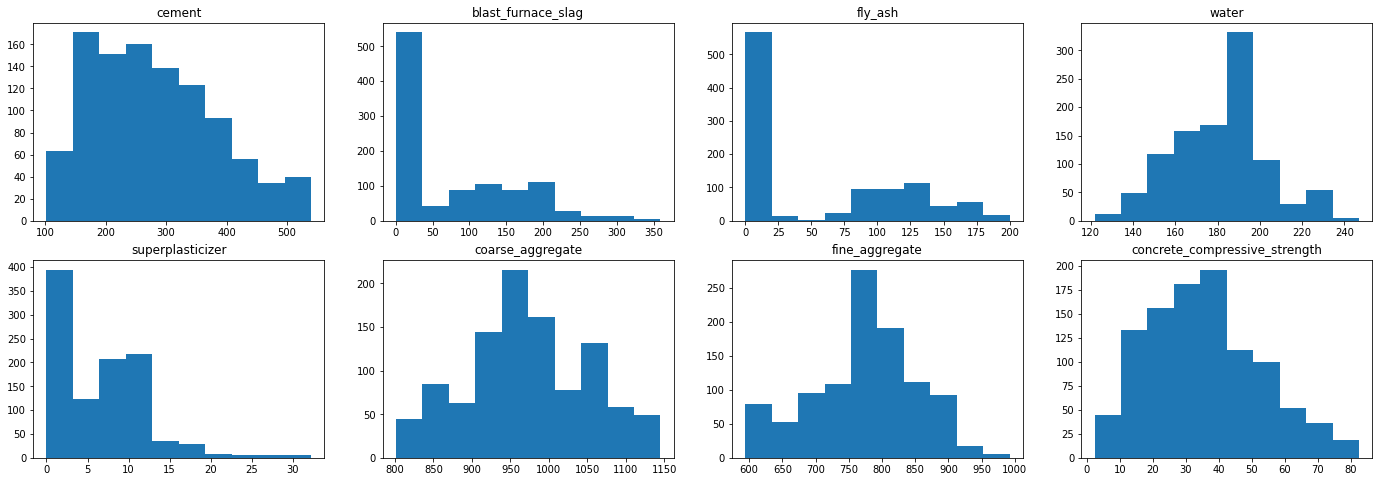

In [6]:
# Plot histograms
_, axes = plt.subplots(2, 4, figsize=(6 * 4, 4 * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df.iloc[:, i])
    ax.set_title(df.columns[i])

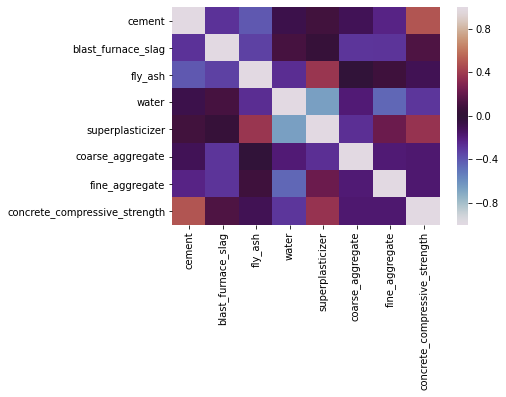

In [7]:
# Look at variable correlations
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='twilight')

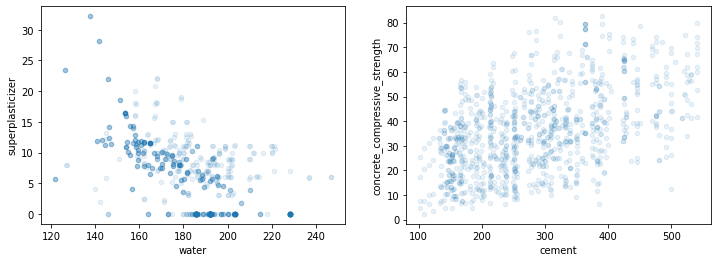

In [8]:
# The biggest correlations are:
# water - superplasticizer
# cement - concrete-compressive-strength

_, axes = plt.subplots(1, 2, figsize=(6 * 2, 4))

df.plot.scatter('water', 'superplasticizer', ax=axes[0], alpha=.1)
df.plot.scatter('cement', 'concrete_compressive_strength', ax=axes[1], alpha=.1)

# Prepare torch dataset

Let's transform our dataset into a torch Tensor, and divide into train, validation and test.

We'll then create a simple flow that learns the dataset distribution.

In [9]:
X = torch.Tensor(df.values)

np.random.seed(123)
torch.random.manual_seed(123)

split = np.random.choice(range(3), replace=True, size=len(X), p=[.75, .15, .1]) # train/val/test
split = torch.Tensor(split) # to tensor

trainX = X[split == 0]
valX = X[split == 1]
testX = X[split == 2]

Our flow will be a MADE - DSF combination. 

But, before that, it is important to normalize the original distribution. 
That's why we use BatchNorm first.

To concatenate several flows together, use the Sequential flow.
Its syntax is equivalent to torch.nn.Sequential.

Finally, we will train with the included train function, that trains flows with early stopping.

In [10]:
from flow.flow import Sequential
from flow.conditioner import MADE
from flow.transformer import DSF
from flow.modules import BatchNorm
from flow.training import train, plot_losses, test_nll, get_device

In [11]:
device = get_device() # returns cuda if available, cpu otherwise
dim = trainX.size(1) # dimension of the flow, 4 in this case

flow = Sequential(
    BatchNorm(dim=dim), # to normalize distribution
    MADE(DSF(dim=dim)) # the actual transformation
).to(device)

410it [01:25,  5.41it/s, current_loss=3.153e+01, best_epoch=310, best_loss=3.028e+01]                    


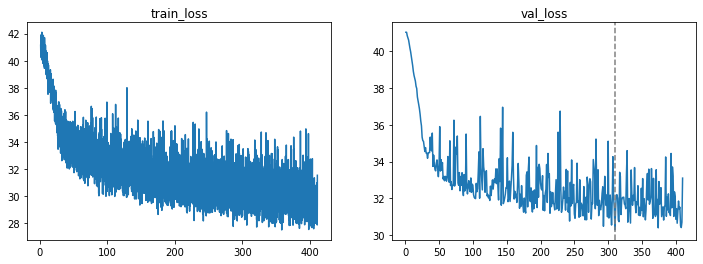

In [12]:
train_losses, val_losses = train(flow, trainX, valX, patience=100)

plot_losses(train_losses, val_losses)

Now that the flow is trained, we can sample and compute log-likelihoods with it.

In [13]:
test_nll(flow, testX) # average negative log-likelihood (nll) of the test set

31.81428837776184

In [14]:
# Want to compute the nll of any sample? Use .nll(sample)

with torch.no_grad(): # no need for gradients now
    nll = flow.nll(testX.to(device)) # remember to move the tensor to the flow's device
    
nll[:5] # show the first 5 nlls of the test set

tensor([26.4787, 21.3921, 24.9708, 34.2106, 25.8014], device='cuda:0')

In [15]:
# Want to generate new samples from the learned distribution? Use .sample(N)

with torch.no_grad():
    sample = flow.sample(1000)
    
# This returns a tensor in the flow's device.
# Let's move it to numpy and transform it to a DataFrame
# to plot its histograms and its correlation heatmap
sample = pd.DataFrame(
    sample.cpu().numpy(),
    columns=df.columns
)

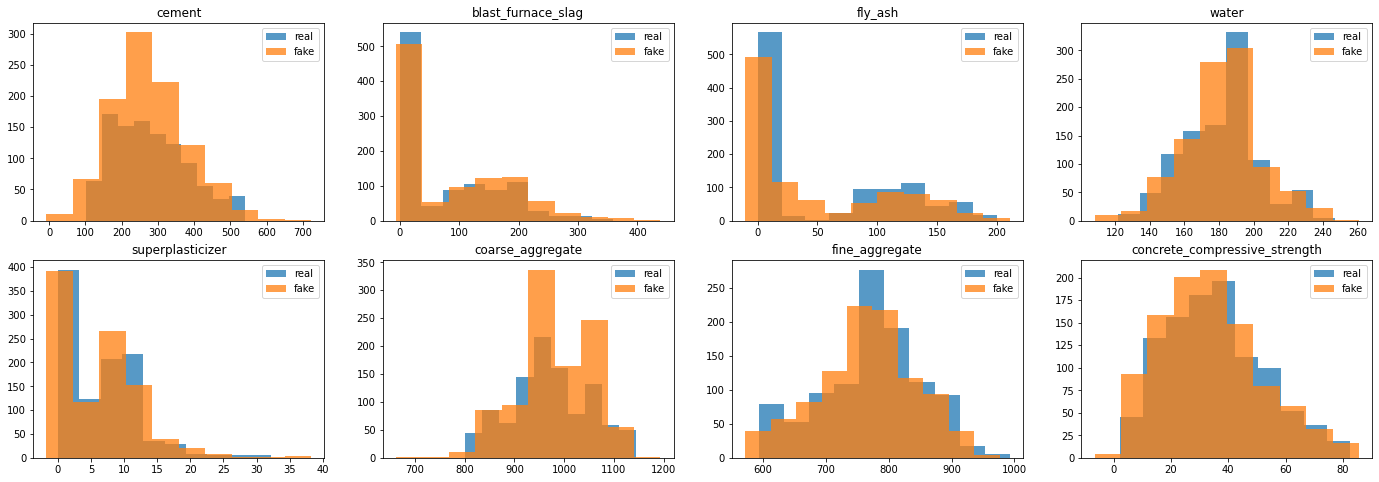

In [16]:
# Plot histograms
_, axes = plt.subplots(2, 4, figsize=(6 * 4, 4 * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df.iloc[:, i], label='real', alpha=.75)
    ax.hist(sample.iloc[:, i], label='fake', alpha=.75)
    ax.set_title(df.columns[i])
    ax.legend()

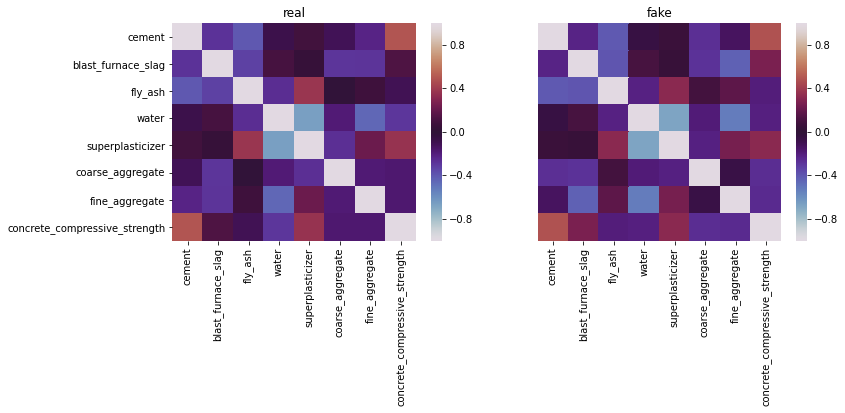

In [17]:
# Look at variable correlations
_, axes = plt.subplots(1, 2, figsize=(6 * 2, 4))

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='twilight', ax=axes[0])
axes[0].set_title('real')
sns.heatmap(sample.corr(), vmin=-1, vmax=1, cmap='twilight', ax=axes[1], yticklabels=False)
axes[1].set_title('fake');

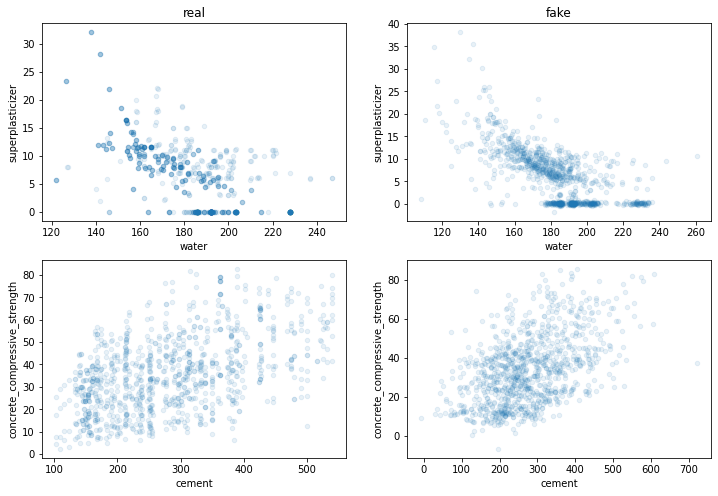

In [18]:
# Check original and sample scatterplots
_, axes = plt.subplots(2, 2, figsize=(6 * 2, 4 * 2))

df.plot.scatter('water', 'superplasticizer', ax=axes[0, 0], alpha=.1, title='real')
sample.plot.scatter('water', 'superplasticizer', ax=axes[0, 1], alpha=.1, title='fake')
df.plot.scatter('cement', 'concrete_compressive_strength', ax=axes[1, 0], alpha=.1)
sample.plot.scatter('cement', 'concrete_compressive_strength', ax=axes[1, 1], alpha=.1)